In [1]:
%matplotlib inline
import pylab
import numpy as np
import nengo


First, here's a quick direct math implementation so we know what we're trying to do:

In [69]:
epsilon = 0.001 

def alpha(x, a=epsilon,b=1.0):
    return (x - (a+b)/2)*2/(b-a)
def ialpha(x, a=epsilon, b=1.0):
    return (x/2*(b-a))+(a+b)/2

def multiply(values, exponents):
    w = exponents / np.sum(np.abs(exponents))
    bias = np.sum(w) - 1    
    log_v = np.log(values) / np.log(epsilon)   
    total = np.sum(w * alpha(log_v)) + bias    
    output = epsilon ** (ialpha(total)*np.sum(np.abs(exponents)))    
    return output
    
multiply([0.5,0.5,0.5], [1.0,1.0,-1.0])    

0.49313974281560607

Now let's build a minimal Nengo model that will compute this same operation.

Note that we are collapsing steps together here.  So instead of using one layer to compute the $\alpha$ transformation and then the next layer to compute the sum, we collapse these feed-forward operations together into a single layer.

By doing this, the multiplicative network only needs one group of neurons: the neurons representing the sum of the transformed components (hidden layer 2 in the original formulation).  All of the transformations into and out of this space are taken care of by Connections into and out of this MultiplicativeNetwork.



In [70]:
class MultiplicativeNetwork(nengo.Network):
    def __init__(self, exponents, epsilon=0.001, n_neurons=200, result_dist=nengo.dists.Uniform(0,1)):
        super(MultiplicativeNetwork, self).__init__()
        self.exponents = np.array(exponents, dtype=float)
        self.w = self.exponents / np.sum(np.abs(self.exponents))
        self.epsilon = epsilon
        
        with self:
            # when connecting to this input, you must apply self.encode_func to transform the data
            self.input = nengo.Node(None, size_in=len(exponents), label='input')
            
            # this is the summed values (hidden layer 2 in the original formulation)
            self.total = nengo.Ensemble(n_neurons=n_neurons, dimensions=1)
            
            # this is the decoded value (output node in the original formulation)
            self.output = nengo.Node(None, size_in=1)
            
            # scale the inputs by w and sum them into the total population
            nengo.Connection(self.input, self.total, transform=[self.w], synapse=None)
            # apply the bias
            self.bias = nengo.Node([np.sum(self.w)-1], label='bias')
            nengo.Connection(self.bias, self.total, synapse=None)
            
            # decode back out to the original 0-1 range
            nengo.Connection(self.total, self.output, function=self.decode_func, synapse=None)
        
        # when computing the output decoder, optimize for data in the given range
        # (note that result_dist is the expected distribution of output values)
        self.total.eval_points = self.encode_func_scaled(result_dist.sample(1000, d=1))
        
        
    # the mapping from total back to the original 0-1 range
    def decode_func(self, x):
        return self.epsilon ** (self.ialpha(x)*np.sum(np.abs(self.exponents)))
    
    # the transformation for a single input
    def encode_func(self, x):
        x = np.maximum(x, self.epsilon)
        return self.alpha(np.log(x)/np.log(self.epsilon))
    
    # the inverse of the decode_func
    def encode_func_scaled(self, x):
        x = np.maximum(x, self.epsilon)
        return self.alpha(np.log(x)/np.log(self.epsilon)/np.sum(np.abs(self.exponents)))
        
    def alpha(self, x):
        a = self.epsilon
        b = 1
        return (x - (a+b)/2)*2/(b-a)
    def ialpha(self, x):
        a = self.epsilon
        b = 1
        return (x/2*(b-a))+(a+b)/2        


Now let's try this out for a random set of inputs.  We'll use 3 inputs and exponents [1, 1, 1].

In [87]:
D = 3
exponents = [1,1,1]

n_samples = 40
samples = np.random.uniform(0,1, size=(n_samples, D))

model = nengo.Network()
with model:
    
    stim = nengo.Node(lambda t: samples[int(t / 0.3) % n_samples])
    p_stim = nengo.Probe(stim, synapse=None)
    
    mult = MultiplicativeNetwork(exponents, epsilon=0.001, n_neurons=200)
    p = nengo.Probe(mult.output, synapse=0.03)
    
    nengo.Connection(stim, mult.input, function=mult.encode_func, synapse=None)

In [88]:
sim = nengo.Simulator(model)
sim.run(10)

Simulation finished in 0:00:03.                                                 


rmse 0.00971032298861


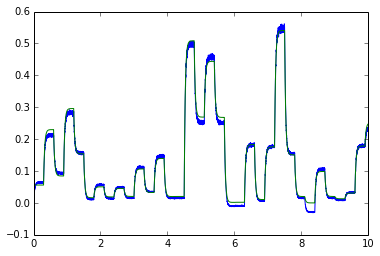

In [89]:
correct = np.ones_like(sim.trange())
for i in range(D):
    correct *= sim.data[p_stim][:,i]**exponents[i]
correct = nengo.synapses.filt(correct,nengo.synapses.Lowpass(0.03),  dt=sim.dt)    
    
pylab.plot(sim.trange(), sim.data[p])
pylab.plot(sim.trange(), correct)    

rmse = np.sqrt(np.mean((sim.data[p][:,0]-correct)**2))
print 'rmse', rmse


For a slightly more realistic example, we should show what happens when we have external populations that represent the inputs and outputs.

In [126]:
D = 3
exponents = [1,1,1]

n_samples = 40
samples = np.random.uniform(0,1, size=(n_samples, D))

model = nengo.Network()
with model:
    
    stim = nengo.Node(lambda t: samples[int(t / 0.3) % n_samples])
    p_stim = nengo.Probe(stim, synapse=None)
    
    inputs = nengo.networks.EnsembleArray(n_neurons=200, n_ensembles=D)
    
    mult = MultiplicativeNetwork(exponents, epsilon=0.001, n_neurons=200)
    
    inputs.add_output('encode', mult.encode_func)
    nengo.Connection(stim, inputs.input, synapse=None)    
    nengo.Connection(inputs.encode, mult.input, synapse=0.01)
    
    output = nengo.Ensemble(n_neurons=200, dimensions=1)
    nengo.Connection(mult.output, output, synapse=0.01)
    p = nengo.Probe(output, synapse=0.03)
    
sim = nengo.Simulator(model)
sim.run(10)    

Simulation finished in 0:00:08.                                                 


rmse 0.0279774264491


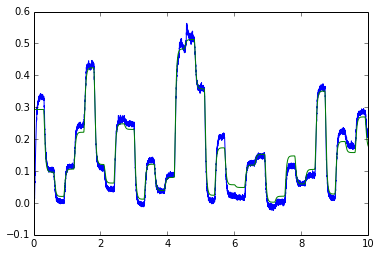

In [127]:
correct = np.ones_like(sim.trange())
for i in range(D):
    correct *= sim.data[p_stim][:,i]**exponents[i]
correct = nengo.synapses.filt(correct,nengo.synapses.Lowpass(0.01),  dt=sim.dt)    
correct = nengo.synapses.filt(correct,nengo.synapses.Lowpass(0.01),  dt=sim.dt)    
correct = nengo.synapses.filt(correct,nengo.synapses.Lowpass(0.03),  dt=sim.dt)    
    
pylab.plot(sim.trange(), sim.data[p])
pylab.plot(sim.trange(), correct)    

rmse = np.sqrt(np.mean((sim.data[p][:,0]-correct)**2))
print 'rmse', rmse

The differences between this version and the version shown above are that we are now introducing new sources of error: the representation of the input values (and its log transformation) and the representation of the output value.  The accuracy of these systems is dependent on the neural systems that are feeding into and reading out of this multiplicative system.